In [1]:

from pgmpy.models import BayesianModel
from pgmpy.estimators import BayesianEstimator
from pgmpy.estimators import ConstraintBasedEstimator
from pgmpy.estimators import K2Score, BicScore, MLE
import networkx as nx
import matplotlib.pyplot as plt
import graphviz
import pandas as pd
import torch
import pyro
import numpy as np
%matplotlib inline
%load_ext autoreload
%autoreload 2

/home/wwymak/anaconda3/envs/immo-ml/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


#### Building a DAG (based on the transport model)

![](survey.png)

1a) factorization of the joint distribution:
    
P(A, S, E, O, R, T) = P(A)P(S)P(E|A, S)P(R|E)P(O|E)P(T| R, O)

1b, c)

In [2]:
transport_model = BayesianModel([('Age', 'Education'), 
                                 ('Sex', 'Education'),
                                 ('Education', 'Occupation'),
                                 ('Education', 'Resident'),
                                 ('Occupation', 'Transport'),
                                 ('Resident', 'Transport')
                                ])

1d)

In [3]:
transport_model

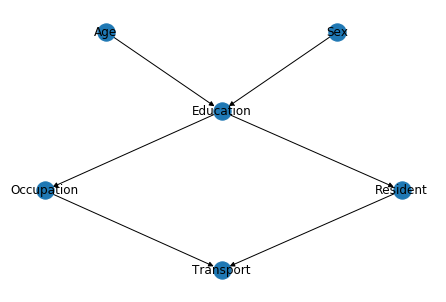

In [4]:
pos1 = nx.nx_pydot.graphviz_layout(transport_model, prog='dot')
nx.draw(transport_model, pos1, with_labels=True)
plt.show()

2a)

In [5]:
transport_model.nodes

NodeView(('Age', 'Education', 'Sex', 'Occupation', 'Resident', 'Transport'))

In [6]:
transport_model.edges

OutEdgeView([('Age', 'Education'), ('Education', 'Occupation'), ('Education', 'Resident'), ('Sex', 'Education'), ('Occupation', 'Transport'), ('Resident', 'Transport')])

2b)

In [7]:
for node in transport_model.nodes:
    print(f"node: {node}, parents: {transport_model.get_parents(node)}, children: {transport_model.get_children(node)}")

node: Age, parents: [], children: ['Education']
node: Education, parents: ['Age', 'Sex'], children: ['Occupation', 'Resident']
node: Sex, parents: [], children: ['Education']
node: Occupation, parents: ['Education'], children: ['Transport']
node: Resident, parents: ['Education'], children: ['Transport']
node: Transport, parents: ['Occupation', 'Resident'], children: []


2c)

In [8]:
#Markov blanket of 'A'
transport_model.get_markov_blanket('Age')

['Sex', 'Education']

In [9]:
#Markov blanket of 'E'
transport_model.get_markov_blanket('Education')

['Sex', 'Age', 'Resident', 'Occupation']

In [10]:
#Markov blanket of 'T'
try:
    transport_model.get_markov_blanket('Transport')
except KeyError as e:
    print(f"Transport has no markov blanket")

Transport has no markov blanket


2d) For each node, it's markov blanket are the set of nodes which if you know the values of (so they are fixed and no longer probabilities), then that node is independent of all the other nodes in the network

2e) The Markov blanket for a node is the set of nodes consisting of the node's parents, it's children, and it's children's other parents.

E.g. for A, it's got no parents, but it has a child('E') and the child has another parent ('S'), so A's markov blanket is S, E

Similarly, for E, parents are A, S, children O, R (these have no other children besides E), so markov blanket for E is A, S, O, R

3a)

In [11]:
data = pd.read_csv('survey2.txt', sep=" ")
data = data.rename(columns={"A": "Age", "R": "Resident", "E": "Education",  "O":"Occupation",
                            "S": "Sex", "T" :"Transport"})



In [12]:
def create_and_fit_model(data, estimator, equivalent_sample_size):
    transport_model = BayesianModel([('Age', 'Education'), 
                                 ('Sex', 'Education'),
                                 ('Education', 'Occupation'),
                                 ('Education', 'Resident'),
                                 ('Occupation', 'Transport'),
                                 ('Resident', 'Transport')
                                ])
    transport_model.fit(data, estimator=estimator, equivalent_sample_size=equivalent_sample_size)
    return transport_model

3b)

In [13]:
equivalent_sample_sizes = [1,10, 20, 100, 1000]
for sz in equivalent_sample_sizes:
    model =  create_and_fit_model(data, BayesianEstimator, sz)
    nodes = ['Age', 'Education', 'Sex', 'Occupation', 'Resident', 'Transport']
    print('equivalent_sample_sizes/iss:', sz)
    for node in nodes:
        
        print(model.get_cpds(node))

equivalent_sample_sizes/iss: 1
+------------+----------+
| Age(adult) | 0.357539 |
+------------+----------+
| Age(old)   | 0.157842 |
+------------+----------+
| Age(young) | 0.484619 |
+------------+----------+
+-----------------+---------------------+---------------------+--------------------+---------------------+---------------------+---------------------+
| Age             | Age(adult)          | Age(adult)          | Age(old)           | Age(old)            | Age(young)          | Age(young)          |
+-----------------+---------------------+---------------------+--------------------+---------------------+---------------------+---------------------+
| Sex             | Sex(F)              | Sex(M)              | Sex(F)             | Sex(M)              | Sex(F)              | Sex(M)              |
+-----------------+---------------------+---------------------+--------------------+---------------------+---------------------+---------------------+
| Education(high) | 0.6389365351

equivalent_sample_sizes/iss: 100
+------------+----------+
| Age(adult) | 0.354386 |
+------------+----------+
| Age(old)   | 0.180702 |
+------------+----------+
| Age(young) | 0.464912 |
+------------+----------+
+-----------------+---------------------+---------------------+---------------------+---------------------+--------------------+--------------------+
| Age             | Age(adult)          | Age(adult)          | Age(old)            | Age(old)            | Age(young)         | Age(young)         |
+-----------------+---------------------+---------------------+---------------------+---------------------+--------------------+--------------------+
| Sex             | Sex(F)              | Sex(M)              | Sex(F)              | Sex(M)              | Sex(F)             | Sex(M)             |
+-----------------+---------------------+---------------------+---------------------+---------------------+--------------------+--------------------+
| Education(high) | 0.6187683284457

As the equivalent sample size increase, the probabilities of nodes which are children of other nodes move more towards 0.5 and away from the extremes of 0 and 1. There is no change for probabilities of nodes that are not children(Age, Sex).

For Age and Sex, since they are not conditioned on any other nodes, their probabilities can be derived from the data directly and hence not affected by changing the equivalent sample size parameter. For the other nodes which are conditioned on other nodes, the equivalent sample size parameter adds extra 'imaginary' observed instances e.g. for `P(E | A='young', S='F')`, you would count how many E='uni' instances when A='young', S='F', and  E='high' instances when A='young', S='F'. The equivalent sample size adds extra counts to both of E='uni' instances when A='young', S='F', and  E='high' instances when A='young', S='F', which means you are less likely to get `P(E='uni' | A='young', S='F') = 0` or `P(E='uni' | A='young', S='F') = 1` due to the extra samples. We can see this effect from the above tables where as equivalent sample size increases, the highest probabilities for R/T/E/O decreases and the lowest probabilities increases

4a)

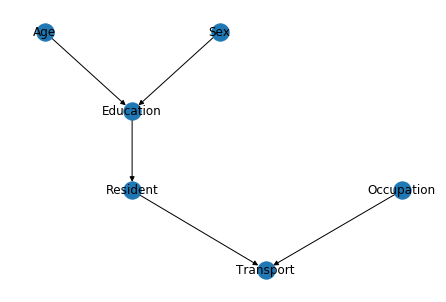

In [14]:
transport_model2 = transport_model.copy()
transport_model2.remove_edge('Education', 'Occupation')
pos2 = nx.nx_pydot.graphviz_layout(transport_model2, prog='dot')
nx.draw(transport_model2, pos2, with_labels=True)


4b)

In [15]:
equivalent_sample_sizes = 1
transport_model2.fit(data, estimator=BayesianEstimator)
transport_model.fit(data, estimator=BayesianEstimator)
nodes = ['Age', 'Education', 'Sex', 'Occupation', 'Resident', 'Transport']

for node in nodes:
    print(node)
    print('original')
    print(transport_model.get_cpds(node))
    print('updated ')
    print(transport_model2.get_cpds(node))

Age
original
+------------+----------+
| Age(adult) | 0.357393 |
+------------+----------+
| Age(old)   | 0.158897 |
+------------+----------+
| Age(young) | 0.483709 |
+------------+----------+
updated 
+------------+----------+
| Age(adult) | 0.357393 |
+------------+----------+
| Age(old)   | 0.158897 |
+------------+----------+
| Age(young) | 0.483709 |
+------------+----------+
Education
original
+-----------------+---------------------+--------------------+---------------------+---------------------+---------------------+---------------------+
| Age             | Age(adult)          | Age(adult)         | Age(old)            | Age(old)            | Age(young)          | Age(young)          |
+-----------------+---------------------+--------------------+---------------------+---------------------+---------------------+---------------------+
| Sex             | Sex(F)              | Sex(M)             | Sex(F)              | Sex(M)              | Sex(F)              | Sex(M)       

The local distributions are all unchanged except for that of the 'Occupation' node

Original factorisation is:
P(A, S, E, O, R, T) = P(A)P(S)P(E|A, S)P(R|E)P(O|E)P(T| R, O)

New factorisation is:
P(A, S, E, O, R, T) = P(A)P(S)P(E|A, S)P(R|E)P(O)P(T| R, O)

So the 'O' node had it's distribution changed from one that is dependent on E to one that isn't. As expected, the distributions on the other nodes hasn't changed as we can see that the factorisation hasn't changed.

5a)

In [16]:
D1 = transport_model.copy()
p1 = ConstraintBasedEstimator.model_to_pdag(D1)

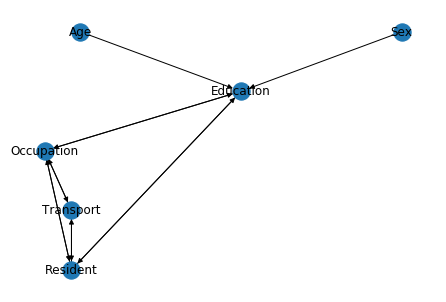

In [17]:
pos3 = nx.nx_pydot.graphviz_layout(p1, prog='dot')
nx.draw(p1,pos3, with_labels=True)
plt.show()

P1 and D1 have the same node/edge combinations. This is because P1 represents the set of equivalent dags of D1, and hence P1 and D1 would have the same skeleton (undirected graph). Any vstructs in D1 should also be preserved in P1 (otherwise it is no longer equivalent as the conditional dependence will be the same)

D1 is more or less all vstructs so there is no difference between D1 and P1 (or at least not in principal, in pgmpy modelling, there is an extra edge between R and O which is rather unexpected and shouldn't be correct...)

5b)

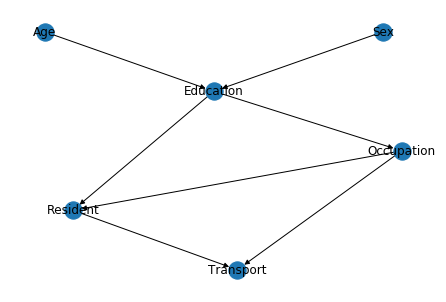

In [18]:

D2 = D1.copy()
D2.add_edge('Occupation', 'Resident')
nx.draw(D2, nx.nx_pydot.graphviz_layout(D2, prog='dot'), with_labels=True)


5c)

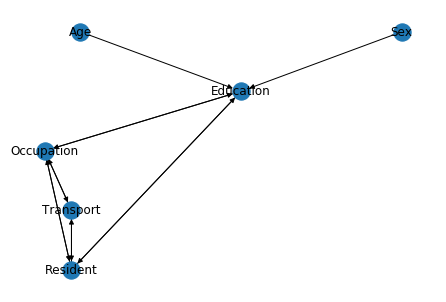

In [19]:
P2 = ConstraintBasedEstimator.model_to_pdag(D2)
nx.draw(P2, nx.nx_pydot.graphviz_layout(P2, prog='dot'), with_labels=True)


5d)

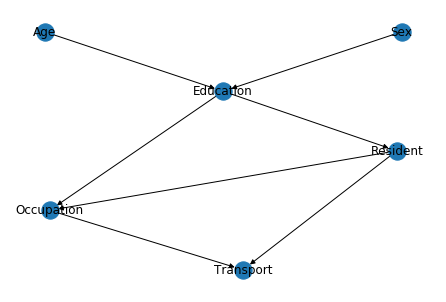

In [32]:

D3= D1.copy()
D3.add_edge('Resident','Occupation')
nx.draw(D3, nx.nx_pydot.graphviz_layout(D3, prog='dot'), with_labels=True)

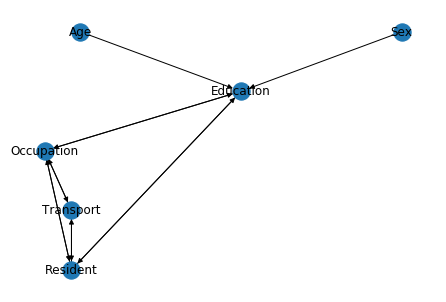

In [21]:
P3 = ConstraintBasedEstimator.model_to_pdag(D3)
nx.draw(P3, nx.nx_pydot.graphviz_layout(P3, prog='dot'), with_labels=True)

5e) The loglikelihood score doesn't seem to be availabe in pgmpy. Here I used another method-- BicScore instead (Bayesian information criterion, which is a modified version of the likelihood score but with a penalty added to stop overfitting) . D2 and D3 share the same score-- this is expected because the score is dependent on the underlying PDags and D2 and D3 have the same dags

In [22]:
BicScore(data).score(D1), BicScore(data).score(D2),BicScore(data).score(D3)

(-2420.007975311849, -2425.3464677738216, -2425.3464677738216)

6a)

In [23]:
def pyro_model():
    A_alias = ['young','adult','old']
    S_alias = ['M','F']
    E_alias = ['high','uni']
    O_alias = ['emp','self']
    R_alias = ['small','big']
    T_alias = ['car','train','other']

    age_probs = torch.tensor([0.48, 0.36, 0.16])
    sex_probs = torch.tensor([0.45, 0.55 ])

    occupation_probs = torch.tensor([
            [0.98, 0.97],
            [0.02, 0.03]
    ]) 
    education_probs = torch.tensor([
            [[0.64, 0.36], [0.84, 0.16], [0.16, 0.84]],
            [[0.72, 0.28], [0.89, 0.11], [0.81, 0.19]]])

    resident_probs = torch.tensor([
            [0.72, 0.94],
            [0.28, 0.06]])
    transport_probs = torch.tensor([[[0.54,0.38,0.07], [0.71, 0.15, 0.14]],
                     [[0.73,0.02,0.25], [0.69,0.18,0.18]]])

    age = pyro.sample("Age", pyro.distributions.Categorical(probs=age_probs)) #young, adult, old
    sex = pyro.sample("Sex",  pyro.distributions.Categorical(probs=sex_probs)) # male, female
    
   
    education = pyro.sample("Education", pyro.distributions.Categorical(probs=education_probs[sex][age]))
    

    occupation  = pyro.sample("Occupation", pyro.distributions.Categorical(occupation_probs[education]))
     # big ,small
    resident  = pyro.sample("Resident", pyro.distributions.Categorical(resident_probs[education]))
    
    
    transport = pyro.sample("Transport", pyro.distributions.Categorical(transport_probs[occupation][resident]))
    
    return{'age': age,
           'sex': sex,
           'education': education,
           'occupation': occupation,
           'resident': resident,
           'transport': transport
          }

In [24]:
pyro_model()

{'age': tensor(0),
 'sex': tensor(0),
 'education': tensor(1),
 'occupation': tensor(0),
 'resident': tensor(0),
 'transport': tensor(0)}

6b)
You observe a person with a university degree. What is your prediction of this person’s means of travel?

so we know eductions="uni"

In [25]:
conditioned_model_uni = pyro.condition(pyro_model, data={"Education": torch.tensor(1), })

Text(0.5, 1.0, 'P(T | E="uni") - Importance Sampling')

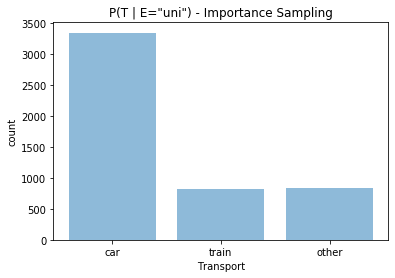

In [26]:
t_posterior = pyro.infer.Importance(conditioned_model_uni, num_samples=5000).run()
t_marginal = pyro.infer.EmpiricalMarginal(t_posterior,"Transport")
t_samples = [t_marginal().item() for _ in range(5000)]
t_unique, t_counts = np.unique(t_samples, return_counts=True)

plt.bar(t_unique, t_counts, align='center', alpha=0.5)
plt.xticks(t_unique, ['car','train','other'])
plt.ylabel('count')
plt.xlabel('Transport')
plt.title('P(T | E="uni") - Importance Sampling')

6c) You observe a self-employed person who lives in a big city. What is your prediction of this person’s
age? Provide either a MAP estimate or a histogram of the marginal on the variable “A”.

In [27]:
conditioned_model_emp_resi = pyro.condition(pyro_model, 
    data={"Resident": torch.tensor(1), "Occupation": torch.tensor(0) })

Text(0.5, 1.0, 'P(A | R="big", E="self") - Importance Sampling')

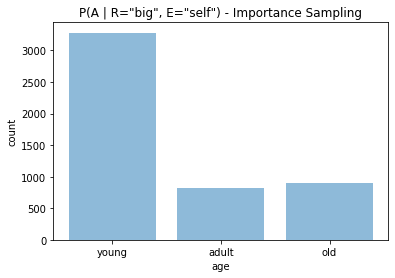

In [28]:
a_posterior = pyro.infer.Importance(conditioned_model_emp_resi, num_samples=5000).run()
a_marginal = pyro.infer.EmpiricalMarginal(a_posterior,"Age")
a_samples = [t_marginal().item() for _ in range(5000)]
a_unique, a_counts = np.unique(a_samples, return_counts=True)

plt.bar(a_unique, a_counts, align='center', alpha=0.5)
plt.xticks(a_unique, ['young','adult','old'])
plt.ylabel('count')
plt.xlabel('age')
plt.title('P(A | R="big", E="self") - Importance Sampling')

In [29]:
c = ConstraintBasedEstimator(data)
pdag = c.skeleton_to_pdag(*c.estimate_skeleton())
pdag.edges() # edges: A->C, B->C, A--D (not directed)

OutEdgeView([('Age', 'Education'), ('Age', 'Sex'), ('Resident', 'Transport'), ('Education', 'Sex'), ('Sex', 'Age'), ('Sex', 'Education')])